In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy
import sys
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]
from tabulate import tabulate

In [2]:
# Data Import

x_raw = np.genfromtxt ("C:/Users/.../gisette_train.data")
y_raw = np.genfromtxt ("C:/Users/.../gisette_train.labels")
xt_raw = np.genfromtxt ("C:/Users/.../gisette_valid.data")
yt_raw = np.genfromtxt ("C:/Users/.../gisette_valid.labels")

In [3]:
# Preprocess data

X_train = normalize(x_raw)
X_test = normalize(xt_raw)
y_train = y_raw
y_test = yt_raw

Implement the FSA variable selection method for linear models and binary classification with the logistic loss, as described in the slides. Use the parameters
$s = 0.001, \mu = 30, N^{iter} = 500$. Take special care to __normalize each column__ of the X matrix to have zero mean and variance I and to use the same mean and standard
deviation that you used for normalizing the train set also for normalizing the test set.

Using the __Gisette__ dataset, train a FSA classifier on the training set, starting with $\beta^{0} = 0$ to select $k \in \{10, 30, 100, 300, 1000\} $ features. 

- Report in a table the misclassification errors on the training and test set for the models obtained for all these $k$. 

- Plot the misclassification error on the training and test set vs $k$.

In [4]:
class FSA:
    def __init__(self, features, learning_rate = 20, iterations = 500, s = 0.001, mu = 30):
        
        self.features = features
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.s = s
        self.mu = mu
        self.likelihoods = []
        self.train_errors = []
        self.test_errors = []
        
    def sigmoid(self, z):
        sig_z = (1/(1+np.exp(-z)))      
        assert (z.shape==sig_z.shape)
        return sig_z
    
    def log_likelihood(self, Xweights, y):
        yXweights = y*Xweights
        loss = np.log(1+np.exp(y-Xweights))
        loss[yXweights<0] = -yXweights[yXweights<0]+np.log(np.exp(yXweights[yXweights<0])+1)
        
        likelihood = np.mean(loss)+self.s*np.sum(self.weights**2)
        return likelihood
    
    def fit(self,X,y,X_test, y_test):
        num_obs = X.shape[0]
        num_feat = X.shape[1]
        
        for k in self.features:
            likelihood = []
            self.weights = np.zeros(num_feat)
            
            for i in range(1,self.iterations+1):
                Xweights = np.dot(X,self.weights)
                sig_Xweights = self.sigmoid(Xweights)
                
                gradient = ((1/X.shape[0])*((1/(1+np.exp(y*Xweights)))*-y)@X)+2*self.s*self.weights
                
                self.weights -= (self.learning_rate)*gradient
                
                M = k+(num_feat - k)*max(0,((self.iterations-2*i)/(2*i*self.mu+self.iterations)))
                M = np.ceil(M).astype(int)
                
                temp = self.weights**2
                
                idx = np.argpartition(temp,-M)[-M:]
                
                mask = np.zeros(self.weights.shape[0],dtype=bool)
                mask[idx] = True
                
                self.weights *= mask
                
                likelihood.append(self.log_likelihood(Xweights,y))
                
            self.likelihoods.append(likelihood)
            
            train_error = self.misclassification_error(y,X)
            self.train_errors.append(train_error)
            
            test_error = self.misclassification_error(y_test, X_test)
            self.test_errors.append(test_error)
            
            
    def predict_proba(self,X):
   
        if self.weights is None:
            raise Exception("Fit the model before prediction")
      
        z = np.dot(X,self.weights)
        probabilities = self.sigmoid(z)
        
        return probabilities
            
    def predict(self, X, threshold=0.5):
        
        binary_predictions = np.array(list(map(lambda x: 1 if x>threshold else -1, self.predict_proba(X))))
        
        return binary_predictions         
            
    def misclassification_error(self,y_true,X):
        preds=self.predict(X)
        error=1-accuracy_score(y_true, preds)
        return error

In [8]:
k = np.array([10,30,100,300,1000])

model = FSA(features=k)
model.fit(X_train, y_train, X_test, y_test)

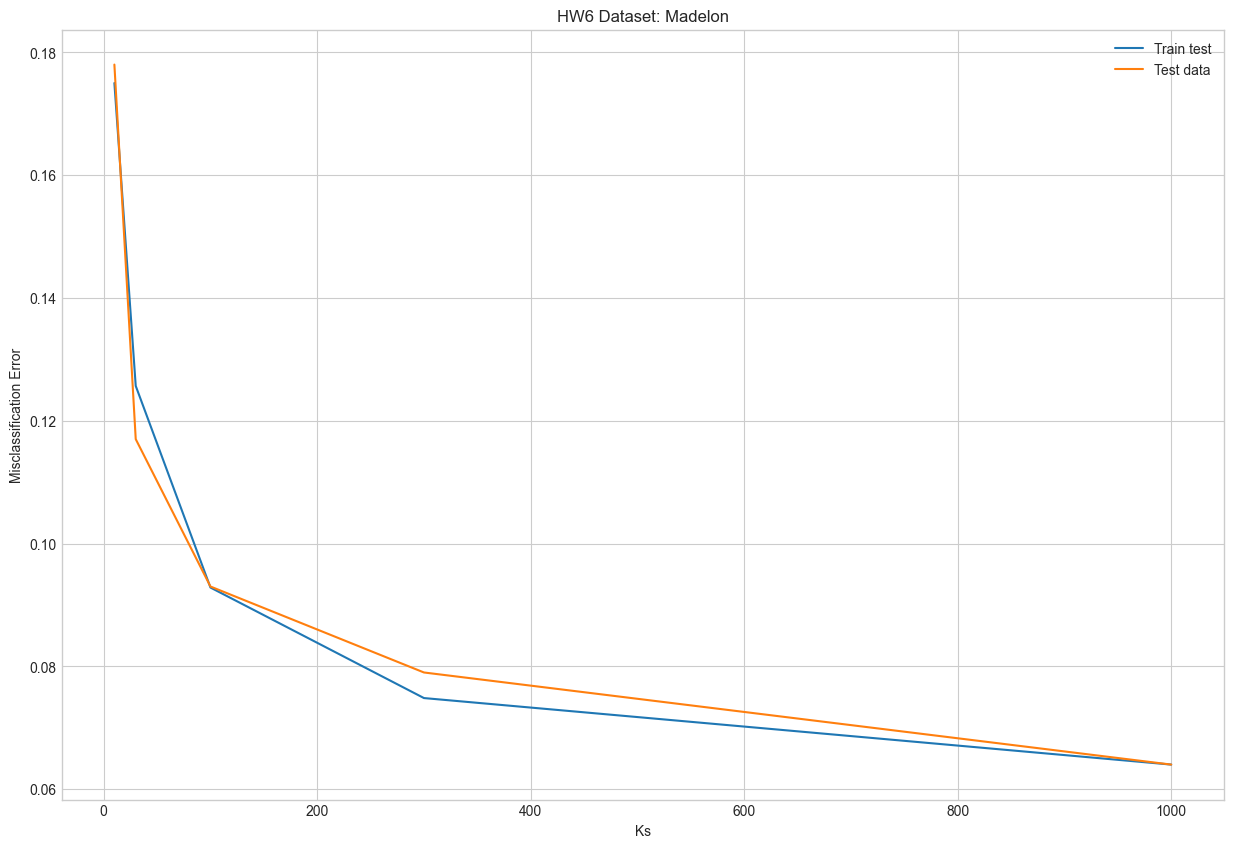

In [9]:
plt.plot(model.features, model.train_errors)
plt.plot(model.features, model.test_errors)
plt.title("HW6 Dataset: Madelon")
plt.legend(['Train test', 'Test data'])
plt.xlabel("Ks")
plt.ylabel("Misclassification Error")
plt.show()

In [10]:
headers =['Ks','Train Error', 'Test Error']
table_sqrt = zip(k,model.train_errors,model.test_errors)
print(tabulate(table_sqrt,headers=headers,tablefmt='fancy_grid'))

╒══════╤═══════════════╤══════════════╕
│   Ks │   Train Error │   Test Error │
╞══════╪═══════════════╪══════════════╡
│   10 │     0.175     │        0.178 │
├──────┼───────────────┼──────────────┤
│   30 │     0.125667  │        0.117 │
├──────┼───────────────┼──────────────┤
│  100 │     0.0928333 │        0.093 │
├──────┼───────────────┼──────────────┤
│  300 │     0.0748333 │        0.079 │
├──────┼───────────────┼──────────────┤
│ 1000 │     0.064     │        0.064 │
╘══════╧═══════════════╧══════════════╛
